In [1]:
import pandas as pd
import numpy as np
import sklearn.decomposition
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import emcee
import tissue_enrichment_analysis as tea
import matplotlib.patheffects as path_effects
import morgan as morgan

import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

import networkx as nx
import matplotlib as mpl


# Display graphics in this notebook
bokeh.io.output_notebook()


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
# sns.set_style('darkgrid', rc=rc)
sns.set_style("dark")

import genpy

ft = 35 #title fontsize

Loading BokehJS ...

In [2]:
phenotype_df = pd.read_csv('../input/dictionaries/phenotype_dictionary.csv')
tissue_df = tea.fetch_dictionary()

# Mutants:

I have been given 4 single mutants and 2 double mutants. This is a blind study, so I don't know the identities of the mutants. 

Single mutants:

b, c, d, e

Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

In [3]:
# Specify the genotypes
single_mutants = ['b', 'c', 'd', 'e']
double_mutants = {'a' : 'bd', 'f':'bc'}

In [4]:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

In [5]:
# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

In [6]:
# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'
thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# PCA Analysis of TPM Data

PCA analysis of TPM data should hopefully reveal some structure and clustering in this dataset. 

First, I want to know how many PCs explain >90% of the data, then build a PCA object with that
many dimensions which I will use for agglomerative clustering. 

In [7]:
# PCA
#exclude g
pca_matrix = genpy.make_matrix(thomas.tpm, thomas.genmap, 'project_name', 'tpm')
sklearn_pca, n = genpy.pca(pca_matrix)

The first 4 principal components explain >=90% of the data


In [8]:
# keep only the first principal components that explain 90% of the data
if n < 3:
    n = 3

df_nD = genpy.tidy_pca(pca_matrix, n)

# add a sample and genotype column
df_nD['samples'] = thomas.genmap.project_name.unique()
l = lambda x: thomas.genmap[thomas.genmap.project_name == x].genotype.values[0]
df_nD['genotypes'] = df_nD.samples.apply(l)
df_nD.head()

,PCA1,PCA2,PCA3,PCA4,samples,genotypes
0,-7597.070087,-2748.583552,-3246.871740,1290.455581,Project_17434_indexN704-N517,wt
1,11507.253519,-2051.481912,-1497.092629,-3054.503202,Project_17441_indexN704-N508,a
2,-3499.905323,5120.560035,-2885.212424,3672.694861,Project_17448_indexN705-N507,d
3,-7673.426882,-2525.724491,-1947.520648,5304.474756,Project_17435_indexN704-N502,wt
4,10090.924838,-3448.230513,-2854.242845,-456.802389,Project_17442_indexN705-N517,a


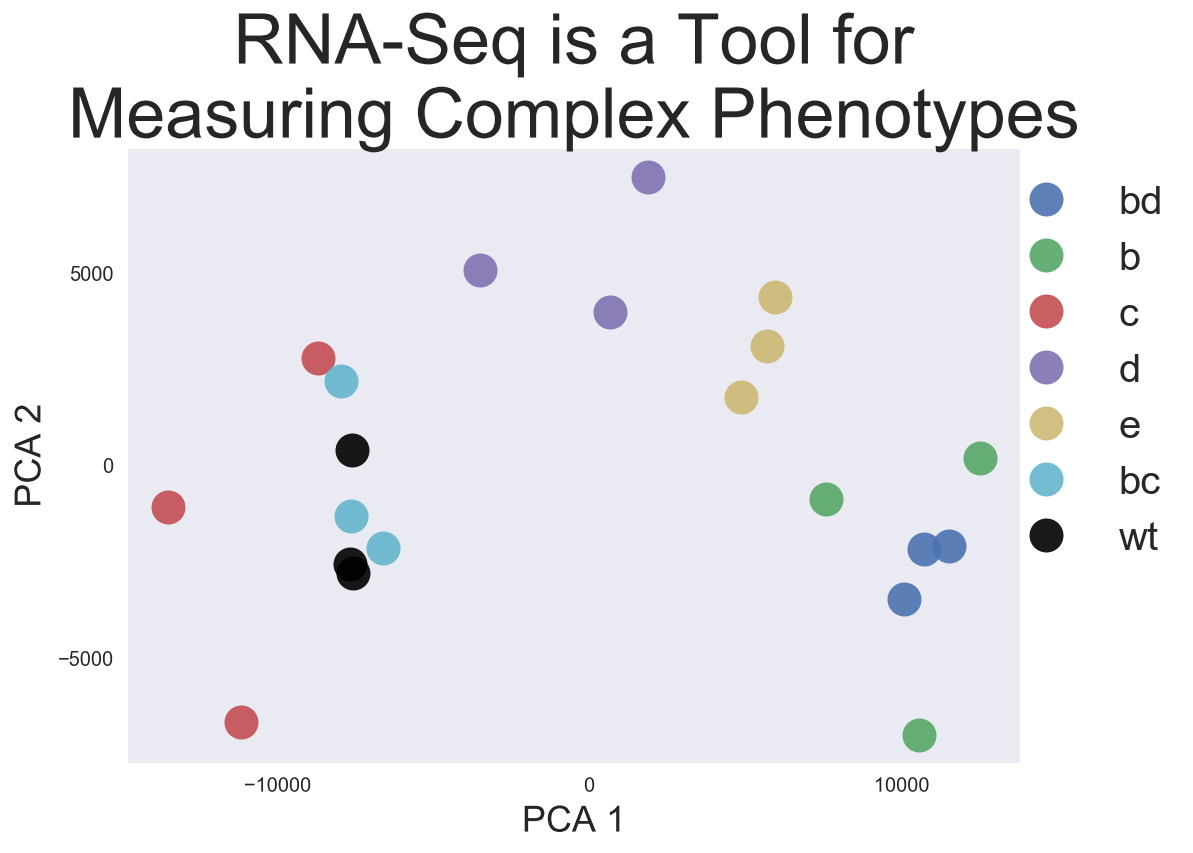

In [9]:
def plot_2d_pca(df_pca, group_col, special_key, double_mutant_hash= {},save=''):
    """
    Very basic wrapper around plt.plot to plot pca results after using tidy_pca.
    
    df_pca - df output by tidy_pca
    group_col - column in df_pca to group by
    special_key - if there's a particular group to color in black, use special_key
                  to identify it
    
    returns:
    a matplotlib object
    """
    # plot first 2d components! 
    for key, group in df_nD.groupby(group_col):
        if key == special_key:
            plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.9, label=key, ms=17)
        else:
            if key not in double_mutant_hash.keys():
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=key, ms=17)
            else:
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=double_mutant_hash[key], ms=17)

    # Tidy up plot
    plt.legend(bbox_to_anchor=(1.2, 1), fontsize=20).set_path_effects([path_effects.Normal()])
    plt.margins(0.05)
    plt.xlabel('PCA 1').set_path_effects([path_effects.Normal()])
    plt.ylabel('PCA 2').set_path_effects([path_effects.Normal()])
    if save:
        plt.savefig(save)
    
    
plot_2d_pca(df_nD, 'genotypes', 'wt', double_mutants)

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()[::1]):
    ax.get_xticklabels()[::1][i] = ax.get_xticklabels()[::1][i].set_path_effects([path_effects.Normal()])

    
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=10**4) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5*10**3) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.title('RNA-Seq is a Tool for\nMeasuring Complex Phenotypes', fontsize=ft).set_path_effects([path_effects.Normal()])
plt.savefig('../output/tpm_pca.pdf', bbox_inches='tight')


Clearly, we can see a few things:

b, e and d all cluster far away from the WT, primarily along PCA1. 

The double mutant f has a mean PCA location very close to b. 

Mathematically:
$$
b^-d^- \sim b^-
$$

The mutant c has a centroid relatively close to the WT. 

The double mutant f is almost identical to the WT:
$$
b^-c^- \sim WT
$$

However, we are only looking at the first 2 dimensions of the PCA, and we know that 90% of the variance is contained in the first 4. So we can perform agglomerative clustering to make sure these observations are correct. 

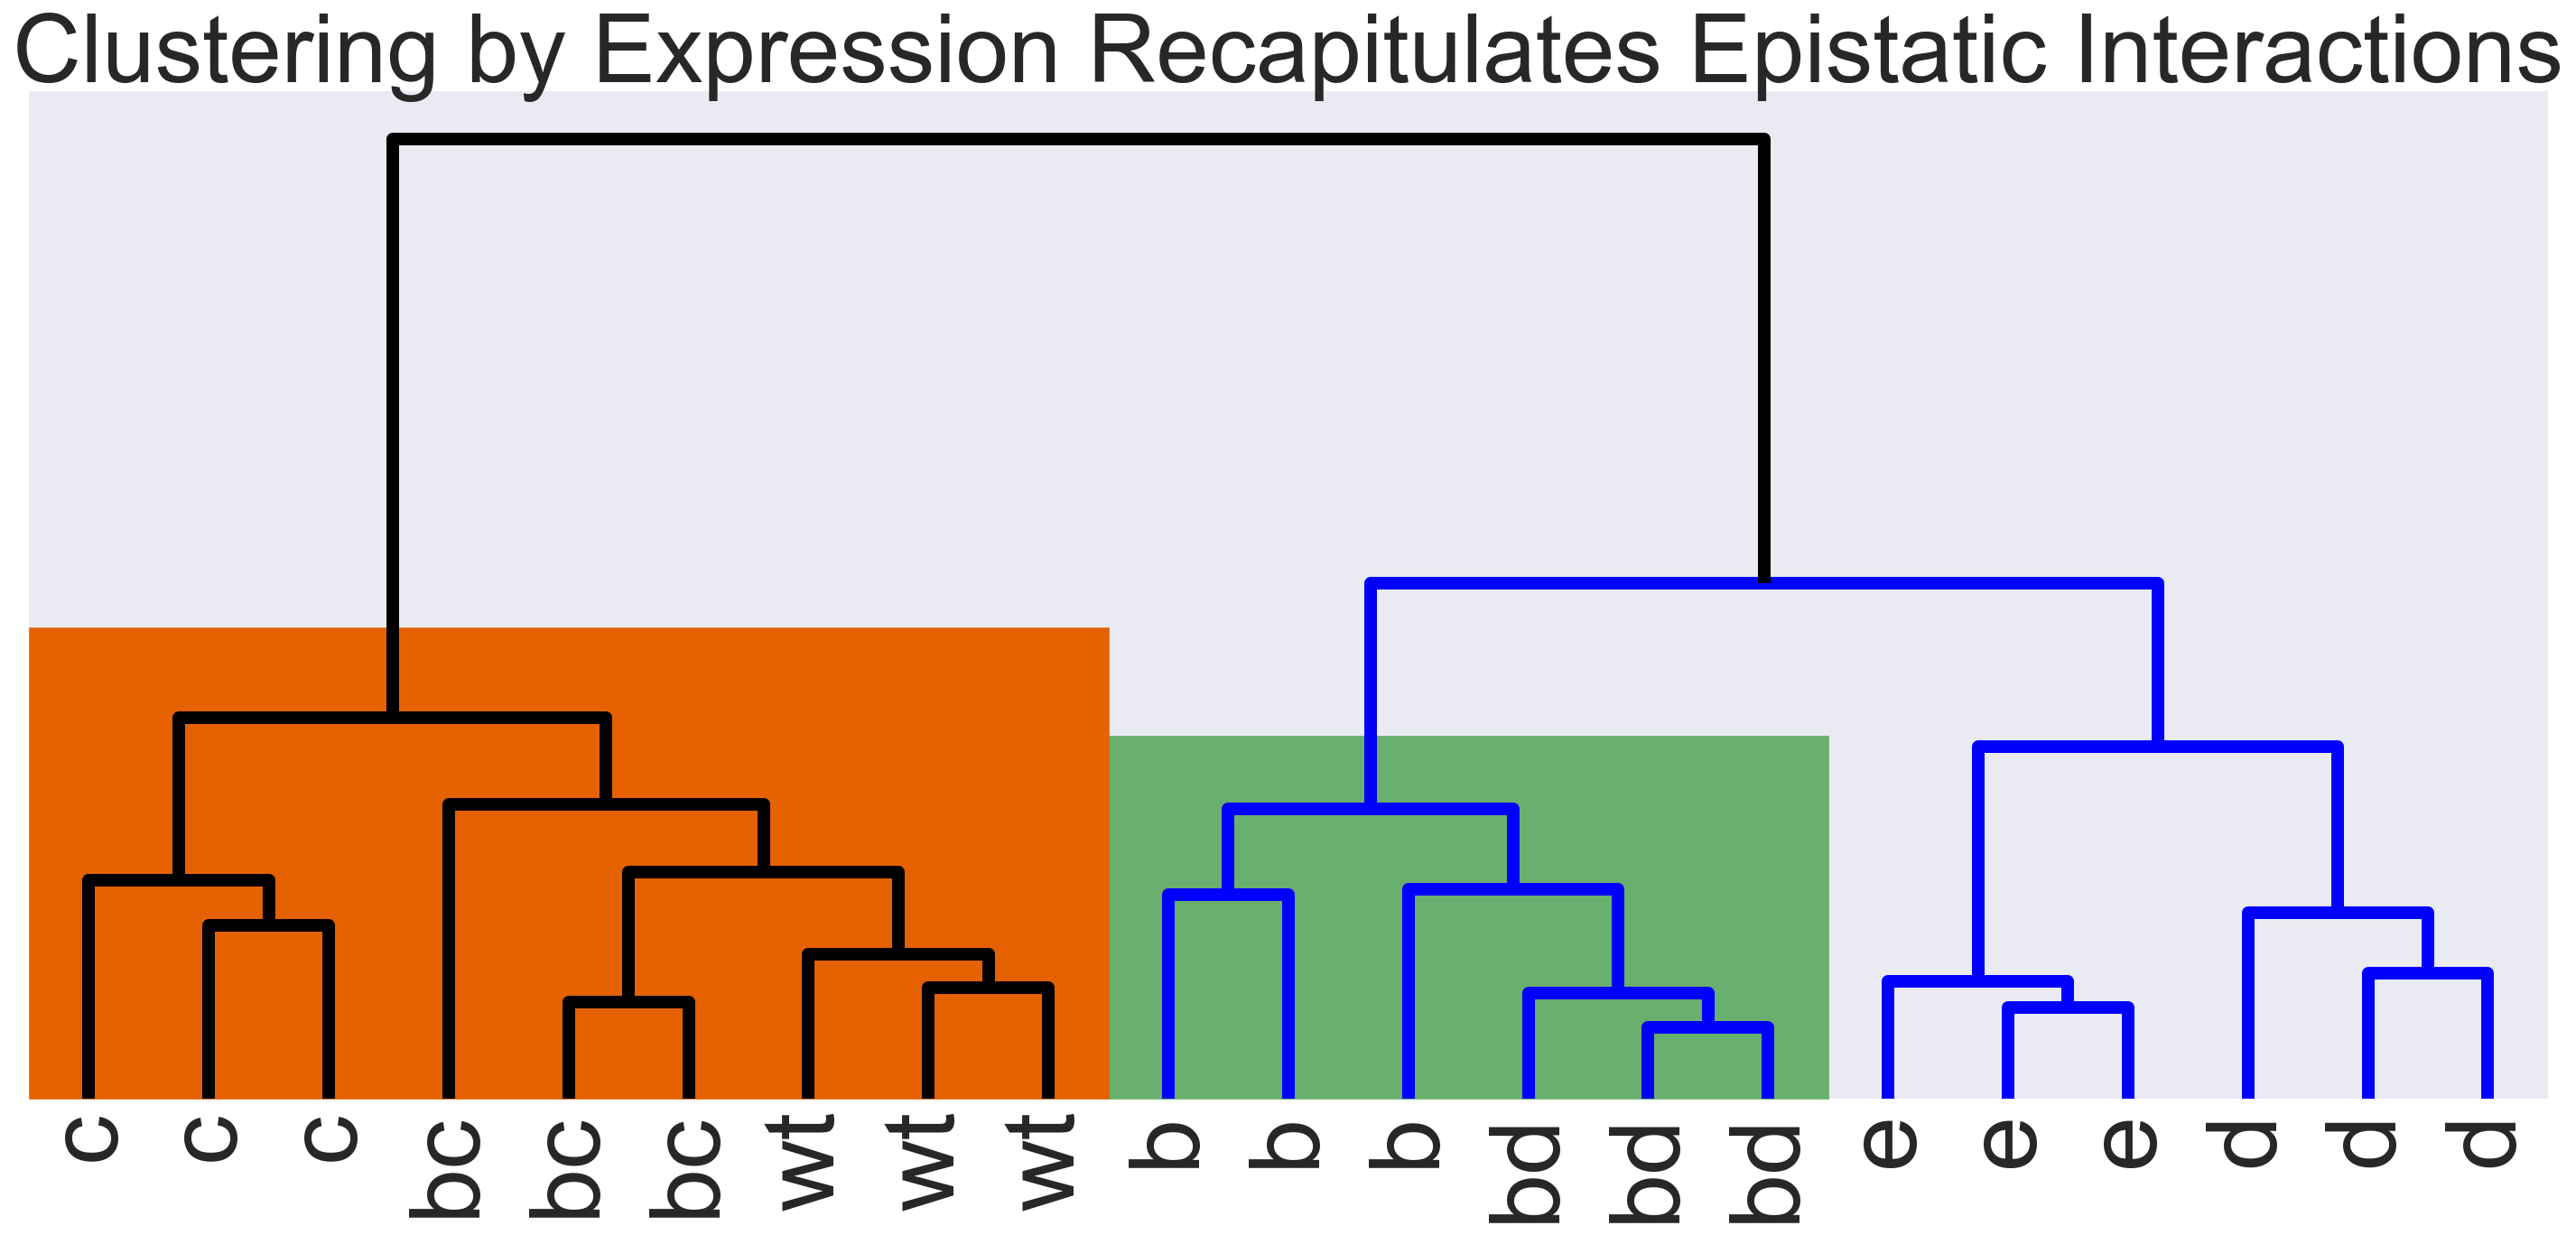

In [10]:
model = hierarchy.linkage(sklearn_pca.transform(pca_matrix), 'ward')
plt.figure(figsize=(25, 10))

labels = df_nD.genotypes.values

for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# ax, fig = plt.subplots()
plt.rcParams['lines.linewidth'] = 7

hierarchy.set_link_color_palette(['k', 'b'])
# fig, ax = plt.subplots()

hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=df_nD.genotypes.values,
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    above_threshold_color='k'
)

ax = plt.gca()
height = ax.get_ylim()[1]*.36
ax.fill_between([90, 150], 0.0, height, 
                    where=[1,1], color='g', alpha=0.55, zorder=0)
ax.fill_between([0, 90], 0.0, height*1.3, 
                    where=[1,1], color='#e66101', alpha=1, zorder=0)

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.yticks(fontsize=30)
plt.title('Clustering by Expression Recapitulates Epistatic Interactions', fontsize=ft*1.5)
# plt.xlabel('sample index', fontsize=40)
# plt.ylabel('distance', fontsize=40)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

In fact, it does appear that 
$$
f \sim WT
$$

$$
a \sim b
$$

$$
|c - WT| = min~|g - WT|~ \mathrm{for }~~ g~\in~[b, c, d, e]
$$

Where this last expression means: C is closest to the WT out of [b, c, d, e]

# PCA Based On Stat. Sig. Gene Changes Is Not Helpful

Before we did PCA based on total TPM counts for every gene. In this next section, we will see that clustering genotypes by statistically significant gene changes is not helpful.

The reason is simple. PCA is a variance maximization tool. Feeding in the calculated log linear regression slopes from sleuth (trimmed so that all the NAs are gone) is (anthropomorphizing) like telling the computer what genes to use to identify each genotype. Feeding in the information about what genes really change will make it easier to find just a very few dimensions that allow us to separate the points easily. So, what we will see is that in general feeding in the log linear regressions will  
* Allow us to find PCA components that better separate each genotype
* Allow us to find less PCA components that cumulatively explain the variance in the data
* As a result of this, more subtle effects can be observed, but tight relationships between genotypes become less obvious (subtle differences play a larger role)

At any rate, it's a good idea to filter the data by TPM, 'fold change' and qvalues, so we will go ahead and do this now. 

In [11]:
# Figure out what genes are in 10% or above expression in TPM for all samples. Delete anything below that...
thomas.filter_data(0, 0.1)

Number of na genes: 983


# Filtering Does Not Seriously Alter Differentially Expressed Genes

In [12]:
q = 0.1
for key, df in thomas.beta.items():
    sig_genes = len(df[df.qval < q])
    mc = np.exp(df[df.qval < q].b.abs().max())
    print('{0} has {1} diff. exp. genes before filtering with mean fold change {2:.2g}'.format(key, sig_genes, mc))

print('-----------\n')
for key, df in thomas.beta_filtered.items():
    sig_genes = len(df[df.qval < q])
    print('{0} has {1} diff. exp. genes after filtering'.format(key, sig_genes))

c has 1026 diff. exp. genes before filtering with mean fold change 3.2e+02
b has 1959 diff. exp. genes before filtering with mean fold change 7.7e+02
a has 3330 diff. exp. genes before filtering with mean fold change 4e+02
e has 2650 diff. exp. genes before filtering with mean fold change 6e+02
f has 381 diff. exp. genes before filtering with mean fold change 1.6e+03
d has 1039 diff. exp. genes before filtering with mean fold change 1.9e+03
-----------

c has 1020 diff. exp. genes after filtering
b has 1913 diff. exp. genes after filtering
a has 3301 diff. exp. genes after filtering
e has 2598 diff. exp. genes after filtering
f has 377 diff. exp. genes after filtering
d has 1025 diff. exp. genes after filtering


# PCA with qvalues or 'fold changes':

The first 2 principal components explain >=90% of the data


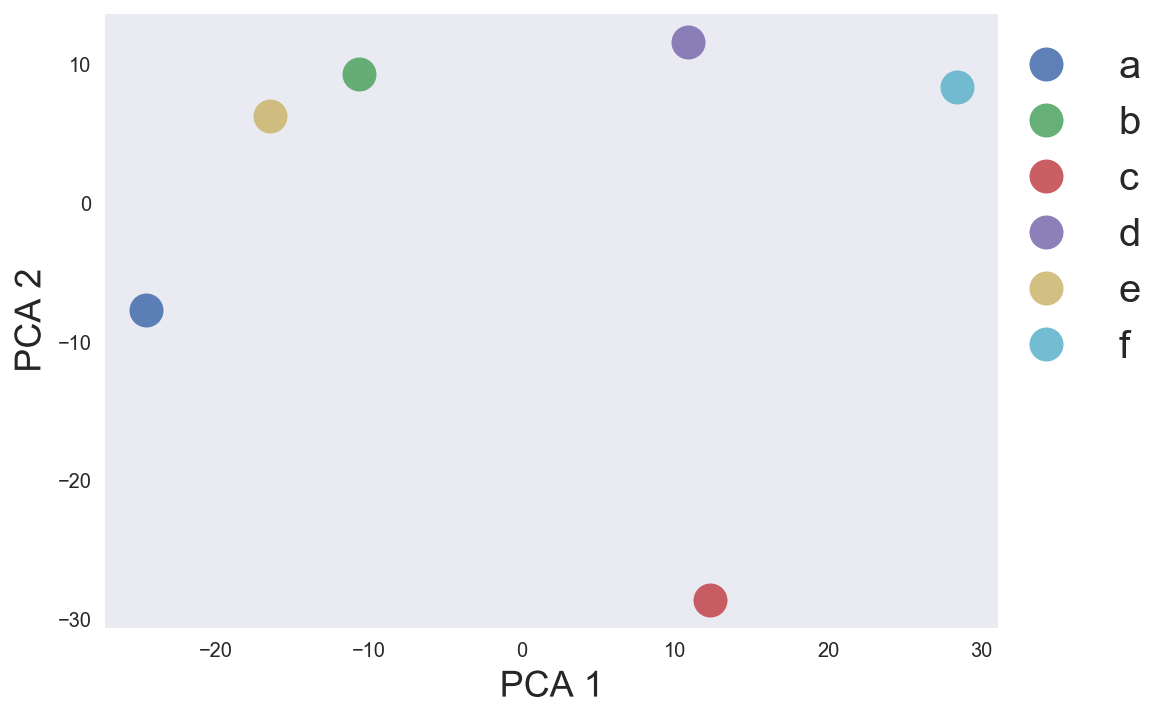

In [13]:
# PCA
pca_matrix = genpy.make_matrix(thomas.beta_filtered, thomas.genmap[(thomas.genmap.genotype != 'wt') ], 'genotype', 'qval')
sklearn_pca, n = genpy.pca(pca_matrix)
# # keep only the first principal components that explain 90% of the data
df_nD = genpy.tidy_pca(pca_matrix, n)

# # add a sample and genotype column
df_nD['genotypes'] = thomas.genmap[(thomas.genmap.genotype != 'wt') ].genotype.unique()
plot_2d_pca(df_nD, 'genotypes', 'wt', save='../output/preliminary_pca.pdf')

# Nomenclature



# Single Mutant Analysis

There seem to be two obvious ways of analyzing this kind of data. By far the simplest method is using Spearman R analysis. 

## Correlational Transcriptome Analysis


## Bayesian Probability of Interaction


## Other kinds of activation



0.96


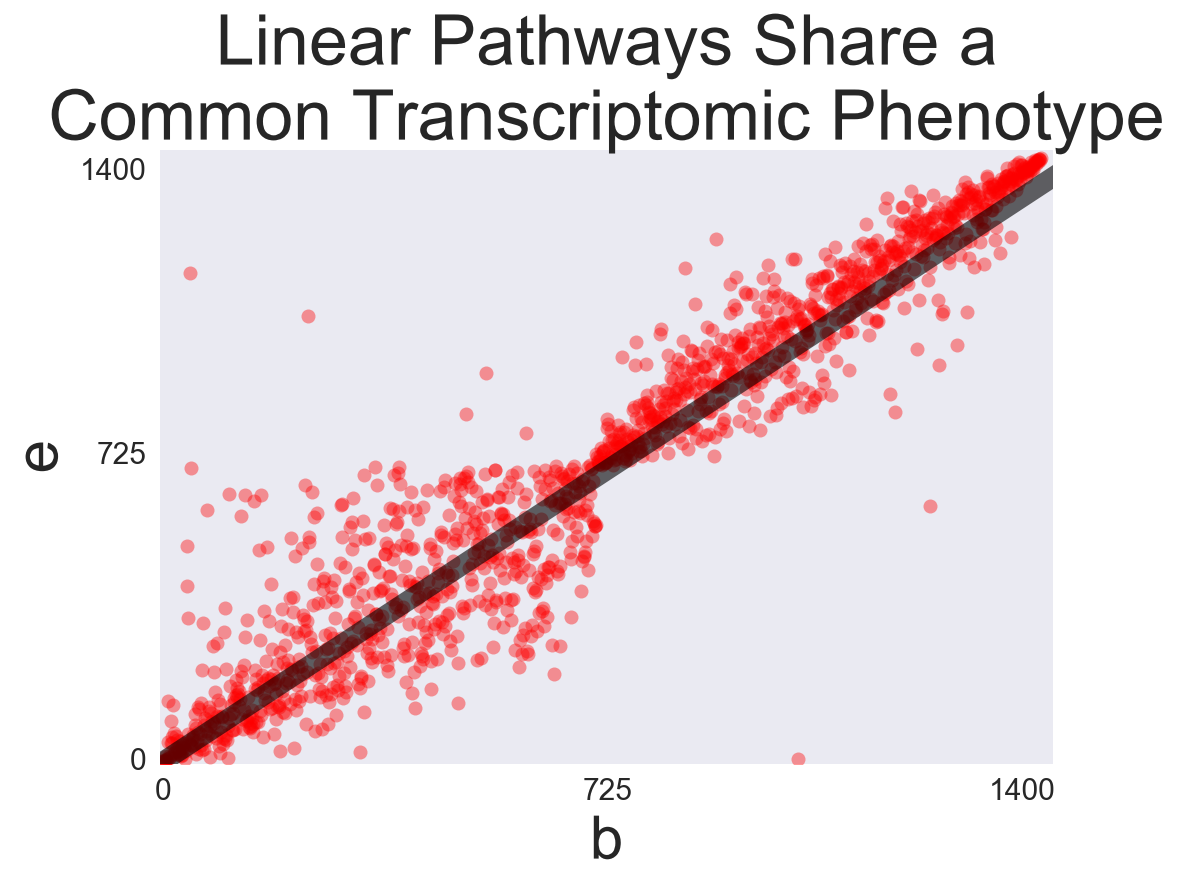

In [14]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

# As an example, let me show you what a good spearman correlation looks like:
genes = 'target_id'

letters = ['b', 'e']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    
    df.sort_values('b', inplace=True)
    rank = np.linspace(0, len(df)-1, len(df))
    df['r'] = rank
    df.sort_values('target_id', inplace=True)

find_rank(ovx)
find_rank(ovy)
find_rank(xns)
find_rank(yns)

r = stats.spearmanr(ovx.b, ovy.b)[0]
X = np.linspace(-5, 1600)
Y = r*X

print('{0:.2g}'.format(r))
plt.plot(ovx.r, ovy.r, 'ro', alpha=0.4, label='Overlapped Diff. Exp. Genes')

plt.plot(X, Y, 'k-', alpha=0.6, lw=10, label= 'Best Fit')

plt.xlim(-5, 1450)
plt.ylim(-5, 1450)

plt.title('Linear Pathways Share a\nCommon Transcriptomic Phenotype', fontsize=ft).\
            set_path_effects([path_effects.Normal()])
plt.xlabel(letters[0], fontsize=30).set_path_effects([path_effects.Normal()])
plt.ylabel(letters[1], fontsize=30).set_path_effects([path_effects.Normal()])

plt.xticks([0, 725, 1400], fontsize=15)
plt.yticks([0, 725, 1400], fontsize=15)

plt.savefig('../output/spearmanr_b_and_c.pdf')

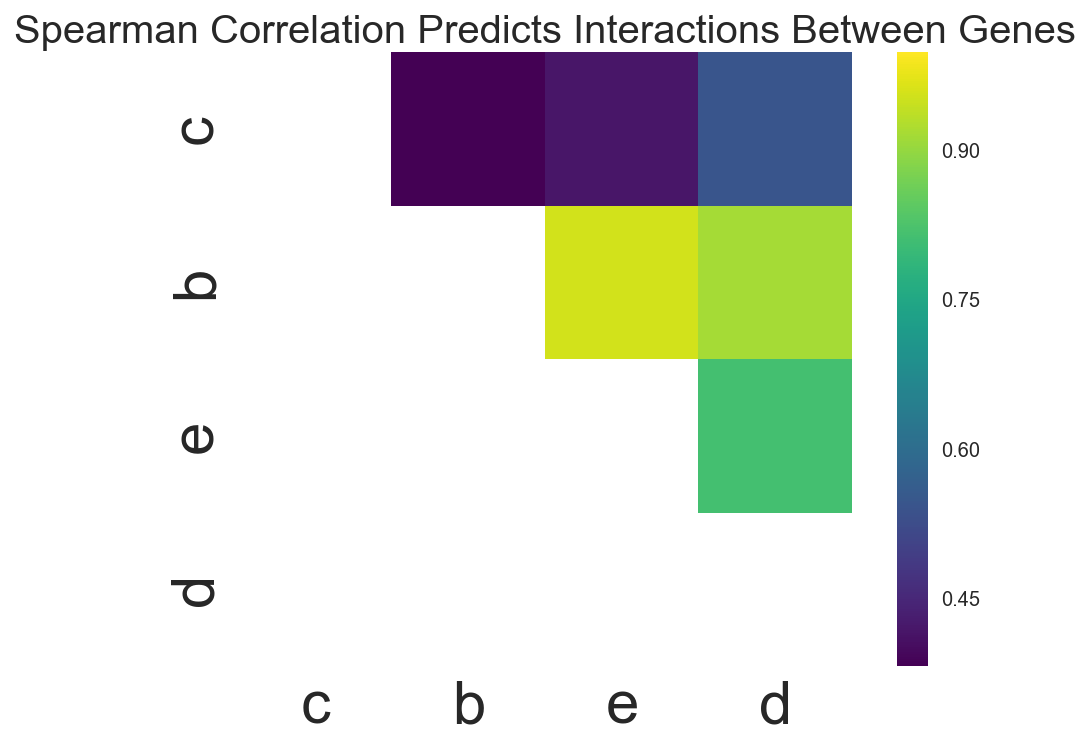

In [15]:
# Perform Correlation Analysis

def tri_plot(matrix, xlabels, ylabels=[]):
    if len(ylabels) == 0:
        ylabels = xlabels
        
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels, yticklabels=ylabels, cmap='viridis',
                         mask=mask, square=True)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

thomas.spearman_analysis()

tri_plot(thomas.rho, thomas.single_mutants)
plt.title('Spearman Correlation Predicts Interactions Between Genes', fontsize=20)
plt.savefig('../output/spearmr_matrix_single_mutants.pdf', bbox_inches='tight')

In [16]:
# Print the spearman correlation matrix viewed above to get the numbers exactly:
thomas.rho

,c,b,e,d
c,1.000000,0.384130,0.418418,0.545602
b,0.384130,1.000000,0.958096,0.916714
e,0.418418,0.958096,1.000000,0.815532
d,0.545602,0.916714,0.815532,1.000000


From the above, we can draw the following arrows:


Interaction | $\rho$ |
----------- | ------- |
b -gp- d| 0.92
b -gp- e| 0.96
d -gp- e| 0.81
d -g- c| 0.53
b -g- c| 0.38
e -g- c| 0.41

Due to the weakness of the spearman correlation of b, d, e with c, we can't draw any conclusions about its sign


c b 1.00
c e 1.00
c d 1.00
b c 1.00
b e 1.00
b d 1.00
e c 1.00
e b 1.00
e d 1.00
d c 1.00
d b 1.00
d e 1.00


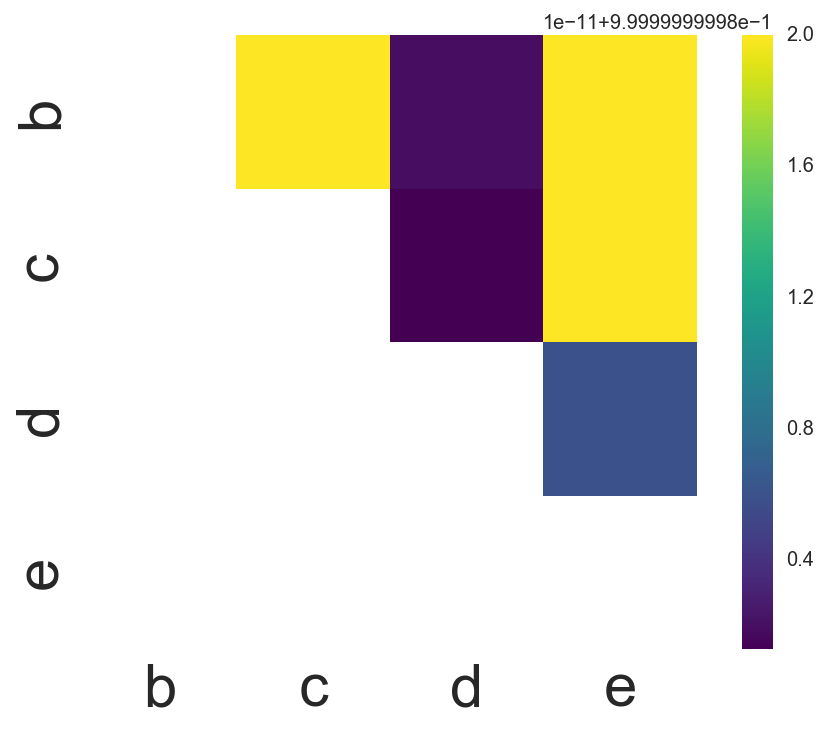

In [50]:
thomas.probabilistic_interaction_analysis()

tri_plot(thomas.prob_plus, single_mutants)
# # print(res_dict['prob_pos'])
# plt.title('Positive Genetic Interaction\nProbability', fontsize=40)
# plt.savefig('../output/probability_of_interaction_single_mutants.pdf', bbox_inches='tight')

              c              b              e             d
c  1.698158e-31   8.378636e-02   9.640674e-06  1.967610e-01
b  8.378636e-02  1.027441e-120  1.677496e-152  2.019743e-41
e  9.640674e-06  1.677496e-152  1.529392e-232  1.776875e-46
d  1.967610e-01   2.019743e-41   1.776875e-46  2.612122e-32


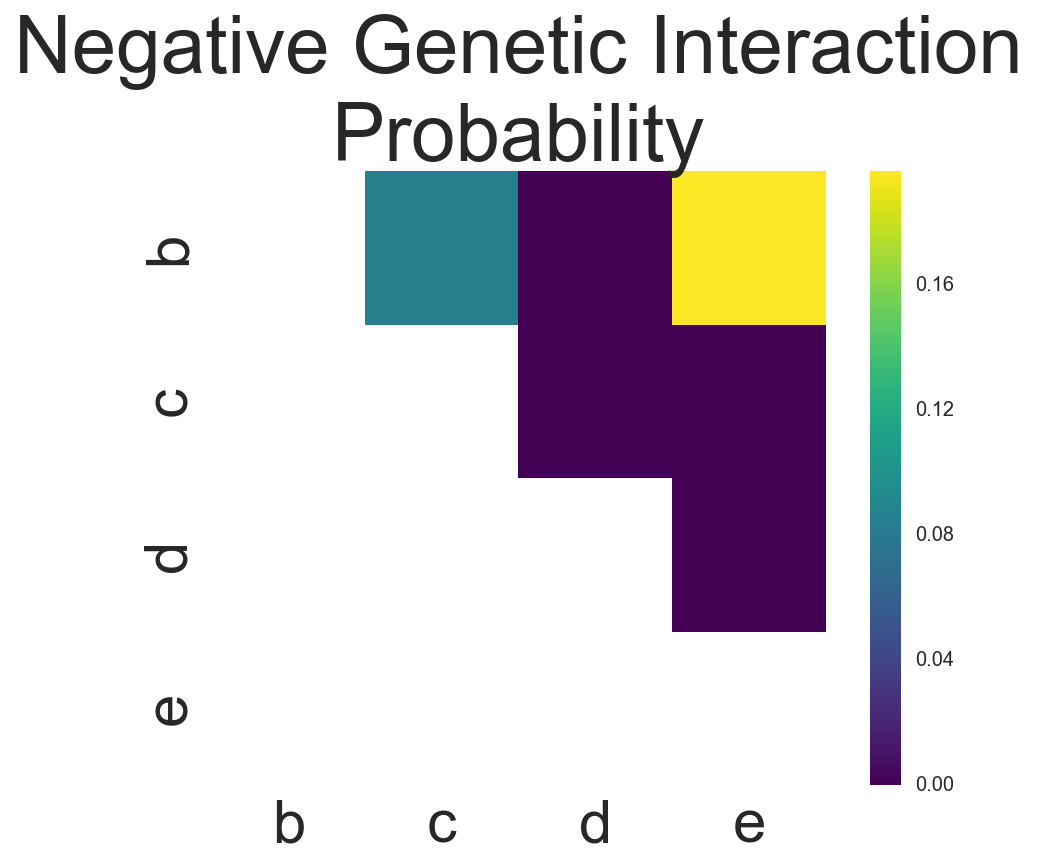

In [56]:
tri_plot(thomas.prob_minus, single_mutants)
print(thomas.prob_minus)
plt.title('Negative Genetic Interaction\nProbability', fontsize=40)
plt.savefig('../output/probability_of_inhibition_single_mutants.pdf', bbox_inches='tight')

In [ ]:
tri_plot(res_dict['overlap_pos'],single_mutants)

In [ ]:
tri_plot(res_dict['overlap_minus'],single_mutants)

# Double Mutant Analysis

With double mutants, the analysis gets slightly more complicated. Now we're getting into full pathways!

A first approach is to inspect the double mutants by Spearman correlation analysis to the single mutants that make them up. A quick visualization will show us any epistasis and the extent of it:

In [ ]:
rho_matrix_doubles = genpy.double_mutant_corr_analysis(double_mutants, beta_filtered)


# tri_plot(rho_matrix_doubles, ['b', 'd','b','c'], ['a', 'f'])
xticklabels = []
yticklabels = []
for key in double_mutants:
    xticklabels += double_mutants[key]
    yticklabels += key
sns.heatmap(rho_matrix_doubles, xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis')


In [ ]:
res_dict_double = genpy.double_mutant_analysis(double_mutants, beta_filtered)

In [ ]:
for key in res_dict_double:
    print(key, res_dict_double[key])

In [ ]:
double_mat = np.zeros(shape=(2, 4))
l = 0
cols = []
for key in double_mutants:
    m = 0
    cols += [key]
    for j in single_mutants:
        x = beta_filtered[key]
        y = beta_filtered[j]
        
        ovx = x[lind(x)]
        ovy = y[lind(y) & y.target_id.isin(ovx.target_id)]
        ovx = x[lind(x) & x.target_id.isin(ovy.target_id)]
        
        rho = stats.spearmanr(ovx.b, ovy.b)
        print(key, j, '{0:.2g}'.format(rho[0]))
        double_mat[l, m] = rho[0]
        m += 1
    l += 1

$$
f^- = b^-d^-
$$

$$
a^- = b^-c^-
$$

$$
b^- = d^- = e^- = b^-c^-
$$
















$$
b^-d^- \sim b^-
$$

$$
b^-d^- \sim c^-
$$

$$
b^-d^- \sim e^-
$$

In [ ]:
double_corr = pd.DataFrame(double_mat.transpose(), columns=cols)
double_corr = pd.melt(double_corr, var_name='double_mutant', value_name='spearmanr')
double_corr['corr_var'] = single_mutants*2

sns.stripplot(x='double_mutant', y='spearmanr', hue='corr_var', data=double_corr, size=15, jitter=True)
plt.legend(bbox_to_anchor= (1.05, 1), fontsize=25)

ax = plt.gca()

xlabels = []
for c in double_corr.double_mutant.unique():
    xlabels += [double_mutants[c]]

# x = np.linspace(0, len(ax.get_xticklabels())-1, len(ax.get_xticklabels()))
plt.xticks(fontsize=ft)
plt.ylabel('Spearman R', fontsize=35)
# plt.xticks(xlabels, fontsize=25)
# plt.title('Double Mutants Have Additive and Epistatic Effects ')
plt.savefig('../output/epistasis_spearmanr.pdf')

In [17]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)

# make sure they all go in the same direction:
ind4 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)

hypoxia_genes = ovb[ind1 & ind2 & ind3 & ind4].copy()

In [18]:
tissue_df = tea.fetch_dictionary()
df_res, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene, tissue_df, save=False)

Executing script

                               Tissue   Expected  Observed  \
0  anal depressor muscle WBbt:0004292  18.313241        35   

   Enrichment Fold Change   P value   Q value  
0                1.911185  0.000049  0.012717  


In [19]:
hypoxia_genes['avg_qval'] = (hypoxia_genes.qval + hypoxia_genes.e_qval + hypoxia_genes.d_qval)/3
hypoxia_genes['avg_b'] = (hypoxia_genes.b + hypoxia_genes.d_b + hypoxia_genes.e_b)/3
hypoxia_genes.sort_values(['avg_qval'], inplace=True)
hypoxia_genes.to_csv('../output/hypoxia_high_confidence.csv', index=False)

# Tissue and Phenotype Enrichment Analyses:

In [22]:
thomas.enrichment_analysis(x= 'ens_gene', analysis='tissue')

Executing script

Executing script

Executing script

Executing script

Executing script

Executing script



In [ ]:
df_phe, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene.unique(), phenotype_df, show=False, save=False)
df_phe.head()

# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [ ]:
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

In [ ]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS, col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0], ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        nhr57 = np.exp(found[found.ens_gene == 'WBGene00003647'].b.values[0])
        print('nhr-57 is in', sm, 'and its fold change was {0:.2g}'.format(nhr57))
    
    print('----------')

In [ ]:
# hypoxia_genes.to_csv('../hypoxia_genes.csv',index=False)
# from bokeh.resources import CDN
# from bokeh.embed import file_html
# from IPython.core.display import HTML

# Use Bokeh chart to make plot
hypoxia_genes['logq'] = -np.log(hypoxia_genes.avg_qval)
hypoxia_genes['logq'] = hypoxia_genes['logq'].astype(np.float64)
hypoxia_genes['avg_b'].astype(np.float64)
hypoxia_genes.logq.fillna(700, inplace=True)
hypoxia_genes.logq.replace([np.inf], 700, inplace=True)
hypoxia_genes.logq.replace([-np.inf], 0, inplace=True)

hypoxia_genes.b.replace([np.inf], 6, inplace=True)
hypoxia_genes.b.replace([-np.inf], -6, inplace=True)
hypoxia_genes.dropna(inplace=True)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label ='PC 1'
p.yaxis.axis_label ='PC 2'

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
source1 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b < 0])
source2 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b > 0])
# Specify data source
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source1, color='blue')
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source2, color='red')
p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
G=nx.Graph()

for i in single_mutants:
    G.add_node(i)

for i, key in enumerate(single_mutants):
    for j, key2 in enumerate(single_mutants):
        r = res_dict['rho'][i, j]
        G.add_edge(key, key2, weight=r)


elarge=[(u,v) for (u,v,d) in G.edges(data=True)]
width=[10*d['weight'] for (u,v,d) in G.edges(data=True)]
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

fig, ax = plt.subplots()

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=1400)

# edges
edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=width, edge_color=weights,
                       edge_cmap=plt.cm.viridis)

# labels
nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')

fig.colorbar(edges)

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display

In [26]:
x = ['WBGene00001851',
     'WBGene00012324',
     'WBGene00001178',
     'WBGene00006922']
for genotype, df in thomas.beta_filtered.items():
    for xi in x:
        dfsig = df[df.qval < q]
        if xi in dfsig.ens_gene.unique():
            if genotype in ['b', 'd', 'e']:
                print('hypoxia', dfsig[dfsig.ens_gene == xi].ext_gene.values, dfsig[dfsig.ens_gene == xi].b.values)
            elif genotype in ['c']:
                print('no hif', dfsig[dfsig.ens_gene == xi].ext_gene.values, dfsig[dfsig.ens_gene == xi].b.values)


no hif ['hif-1' 'hif-1'] [-1.55062087 -2.26086652]
no hif ['rhy-1'] [ 0.45834872]
hypoxia ['rhy-1'] [ 2.52830236]
hypoxia ['egl-9'] [ 1.32586701]
hypoxia ['rhy-1'] [ 1.49533234]
hypoxia ['egl-9'] [ 0.81007544]
hypoxia ['rhy-1'] [ 1.36599195]
hypoxia ['egl-9'] [ 1.16888823]


In [23]:
thomas.enrichment['tissue']

{'a':                                Tissue    Expected  Observed  \
 1                 oocyte WBbt:0006797   28.392095        58   
 3             hypodermis WBbt:0005733  291.699605       363   
 2            spermatheca WBbt:0005319  104.233992       144   
 0  anal depressor muscle WBbt:0004292   83.815020       118   
 4     reproductive tract WBbt:0005744  216.830040       264   
 5                     AB WBbt:0004015    6.417391        15   
 
    Enrichment Fold Change       P value       Q value  
 1                2.042822  2.485929e-09  6.438555e-07  
 3                1.244431  1.884451e-08  2.440364e-06  
 2                1.381507  3.610161e-06  3.116772e-04  
 0                1.407862  1.077827e-05  6.978932e-04  
 4                1.217543  2.947973e-05  1.527050e-03  
 5                2.337398  1.526181e-04  6.588016e-03  ,
 'b':                                Tissue    Expected  Observed  \
 1             hypodermis WBbt:0005733  192.687747       258   
 0  anal dep

In [46]:
rhy1 = thomas.beta_filtered['e'][(thomas.beta_filtered['e'].qval < q) & (thomas.beta_filtered['e'].b > 0)].target_id.values

In [47]:
len(rhy1)

1273

b 5
['mthf-1' 'C49G7.12' 'sax-2' 'sax-2' 'F23F12.12']
d 20
['lys-7' 'C39E9.8' 'C49G7.10' 'C53A3.2' 'ugt-41' 'lips-10' 'F14H12.3'
 'F18E3.11' 'F18E3.13' 'sax-2' 'F23F12.12' 'F41C3.2' 'grl-4' 'cpr-4'
 'H18N23.2' 'asns-2' 'gln-3' 'Y43F8B.2' 'Y43F8B.2' 'hmit-1.2']
